# Contraction Analysis-based Trajectory Stabilization

In [ ]:
# python libraries
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

# pydrake imports
from pydrake.all import (LinearQuadraticRegulator, MathematicalProgram, Variables,
                         Solve, RealContinuousLyapunovEquation)
import pydrake.symbolic as sym

# underactuated imports
from underactuated import plot_2d_phase_portrait

# increase default size matplotlib figures
from matplotlib import rcParams
plt.rcParams.update({'font.size': 18})

In [ ]:
%env MOSEKLM_LICENSE_FILE = "mosek.lic"
from pydrake.solvers.mosek import MosekSolver
from pydrake.solvers.snopt import SnoptSolver
from pydrake.solvers.ipopt import IpoptSolver

env: MOSEKLM_LICENSE_FILE="mosek.lic"


In [ ]:
def contraction_lin_auto():
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    A = np.array([[-1.0, 0.0], [0.0, -1.0]])
    # f = A.dot(x) + B

    M_poly_deg = 0
    M_11 = prog.NewFreePolynomial(Variables(x), M_poly_deg).ToExpression()
    M_12 = prog.NewFreePolynomial(Variables(x), M_poly_deg).ToExpression()
    M_22 = prog.NewFreePolynomial(Variables(x), M_poly_deg).ToExpression()

    M = np.array([[M_11, M_12], [M_12, M_22]])

    R = (M.dot(A)).transpose() + M.dot(A)

    y = prog.NewIndeterminates(2, "y")
    P_M = y.dot(M).dot(y)
    P_R = -y.dot(R).dot(y)

    eps = 1e-4
    lam = 1
    prog.AddSosConstraint(P_M - eps*y.dot(y))
    prog.AddSosConstraint(P_R - eps*y.dot(y) - 2*lam*y.dot(M).dot(y))

    prog.AddCost(0)

    # print(prog)
    solver = MosekSolver()
    result = solver.Solve(prog)
    if result.is_success:
        print("success")
        print(result)
        print(result.GetSolution(M))
        print(result.GetSolution(R))
        return result.GetSolution(M)
    else:
        print("Could not find a contraction metric")

In [ ]:
M_lin = contraction_lin_auto()
M_lin = sym.Evaluate(M_lin)

success
[[<Expression "0.47143819441139706"> <Expression "0">]
 [<Expression "0"> <Expression "0.47143819441139789">]]
[[<Expression "-0.94287638882279412"> <Expression "0">]
 [<Expression "0"> <Expression "-0.94287638882279579">]]


In [ ]:
def stable_lin(t, x): 
    A = np.array([[-1.0, 0.0], [0.0, -1.0]])
    return A.dot(x)

In [ ]:
sol_1 = solve_ivp(stable_lin, [0, 2], [10, 5], t_eval = np.linspace(0, 2, 51))
sol_2 = solve_ivp(stable_lin, [0, 2], [20, 30], t_eval = np.linspace(0, 2, 51))
# print(sol_1.t)
# print(sol_1.y[0])
print(np.shape(sol_1.y)[1])

51


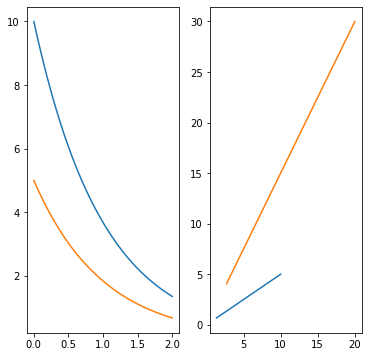

In [ ]:
fig, ax = plt.subplots(1, 2)  # Create a figure containing a single axes.
ax[0].plot(sol_1.t, sol_1.y[0])  # Plot some data on the axes.
ax[0].plot(sol_1.t, sol_1.y[1])
ax[1].plot(sol_1.y[0], sol_1.y[1])
ax[1].plot(sol_2.y[0], sol_2.y[1])

In [ ]:
def RM_dist_st_line(M, x1, x2):
    N = np.shape(x1)[1]
    D = np.zeros(N)
    for i in range(N):
        d_i = x1[:, i] - x2[:, i]
        D[i] = np.sqrt(d_i.transpose().dot(M).dot(d_i))
    return D

Text(0, 0.5, '$\\|x_1(t) - x_2(t)\\|_M$')

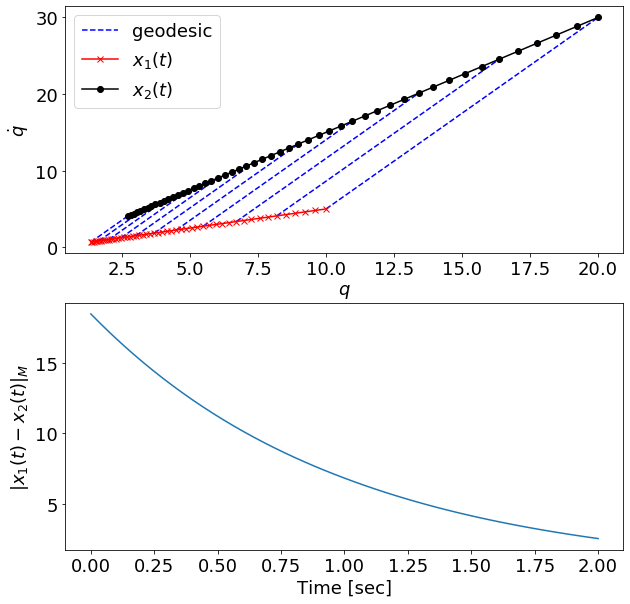

In [ ]:
D = RM_dist_st_line(M_lin, sol_1.y, sol_2.y)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
for i in range(0, np.shape(sol_1.y)[1], 5):
    geo,  = ax[0].plot([sol_1.y[0, i], sol_2.y[0, i]], [sol_1.y[1, i], sol_2.y[1, i]], 'b--')
traj_1, = ax[0].plot(sol_1.y[0], sol_1.y[1], 'rx-')
traj_2, = ax[0].plot(sol_2.y[0], sol_2.y[1], 'ko-')
ax[0].set_xlabel(xlabel=r"$q$")
ax[0].set_ylabel(r"$\dot{q}$")
ax[0].legend([geo, traj_1, traj_2], ['geodesic', r'$x_1(t)$', r'$x_2(t)$'])
ax[1].plot(sol_1.t, D)
ax[1].set_xlabel("Time [sec]")
ax[1].set_ylabel(r"$\|x_1(t) - x_2(t)\|_M$")

In [ ]:
def sos_jet_auto():
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    f = [-x[1] - 3/2*x[0]**2 - 1/2*x[0]**3, 3*x[0] - x[1]]

    M_poly_deg = 4
    M_11 = prog.NewFreePolynomial(Variables(x), M_poly_deg).ToExpression()
    M_12 = prog.NewFreePolynomial(Variables(x), M_poly_deg).ToExpression()
    M_22 = prog.NewFreePolynomial(Variables(x), M_poly_deg).ToExpression()

    M = np.array([[M_11, M_12], [M_12, M_22]])
    M_11_dot = M_11.Jacobian(x).dot(f)
    M_12_dot = M_12.Jacobian(x).dot(f)
    M_22_dot = M_22.Jacobian(x).dot(f)
    M_dot = np.array([[M_11_dot, M_12_dot], [M_12_dot, M_22_dot]])

    dfdx = [[-3*x[0] - 3/2*x[0]**2, -1], [3, -1]]

    # lam = prog.NewContinuousVariables(1, "lam")[0]
    lam = 0.2
    R = (M.dot(dfdx)).transpose() + M.dot(dfdx) + M_dot + 2*lam*M
    # R = (M.dot(dfdx)).transpose() + M.dot(dfdx) + M_dot

    y = prog.NewIndeterminates(2, "y")
    P_M = y.dot(M).dot(y)
    P_R = -y.dot(R).dot(y)

    eps = 1e-8
    prog.AddSosConstraint(P_M - eps*y.dot(y))
    prog.AddSosConstraint(P_R - eps*y.dot(y))
    # prog.AddSosConstraint(P_R - eps*y.dot(y) - 2*lam*y.dot(M).dot(y))

    prog.AddCost(0)

    # print(prog)
    solver = MosekSolver()
    result = solver.Solve(prog)
    if result.is_success:
        # print("success")
        # print(result)
        print(result.GetSolution(M))
        # print(result.GetSolution(R))
        return result.GetSolution(M)
    else:
        print("Could not find a contraction metric")

In [ ]:
print(x)

[Variable('x(0)', Continuous) Variable('x(1)', Continuous)]


In [ ]:
# Hard code contraction metric for now, need an sym.expression kind of translation
def M_jet_auto(x):
    # M = np.empty((2, 2))
    # M[0, 0] = 2.4870017238431377 - 1.971191462347009 * x[0] + 1.9095848949681482 * x[1] - 1.0040948050643186 * (x[0] * x[1]) - 0.18203875990415075 * (x[0] * pow(x[1], 2)) - 0.025124484027558153 * (x[0] * pow(x[1], 3)) + 0.47226226129351495 * (pow(x[0], 2) * x[1]) + 0.24185774740834914 * (pow(x[0], 2) * pow(x[1], 2)) - 0.071330581246771968 * (pow(x[0], 3) * x[1]) + 1.113774990945444 * pow(x[0], 2) - 0.33615870618145766 * pow(x[0], 3) + 0.2888564217474166 * pow(x[0], 4) + 1.4113979883427432 * pow(x[1], 2) + 0.57489770786184036 * pow(x[1], 3) + 0.097500015074184307 * pow(x[1], 4)
    # M[0, 1] = -0.29387276009199259 + 1.613523655319353 * x[0] - 0.23653010489727561 * x[1] + 0.71716118332911138 * (x[0] * x[1]) - 0.031810702682074643 * (x[0] * pow(x[1], 2)) - 0.040989895673695848 * (x[0] * pow(x[1], 3)) - 0.10876700189410779 * (pow(x[0], 2) * x[1]) + 0.032350998047370134 * (pow(x[0], 2) * pow(x[1], 2)) - 0.02906643017014671 * (pow(x[0], 3) * x[1]) - 0.77749172663273691 * pow(x[0], 2) + 0.23780282347905099 * pow(x[0], 3) - 0.03470997505725168 * pow(x[0], 4) - 0.13489597236860193 * pow(x[1], 2) - 0.022754321484553582 * pow(x[1], 3)
    # M[1, 0] = M[0, 1]
    # M[1, 1] = 0.79602640350481857 - 0.72438821274474607 * x[0] + 1.0470048095687106 * x[1] - 0.47433440128757498 * (x[0] * x[1]) - 0.043636882343201761 * (x[0] * pow(x[1], 2)) + 0.89673464020956362 * (pow(x[0], 2) * x[1]) + 0.18232444177139387 * (pow(x[0], 2) * pow(x[1], 2)) - 0.12281160582630909 * (pow(x[0], 3) * x[1]) + 1.5053710868921053 * pow(x[0], 2) - 0.25267611128820844 * pow(x[0], 3) + 0.16214280223218602 * pow(x[0], 4) + 0.63797119676611269 * pow(x[1], 2) + 0.17178144647820323 * pow(x[1], 3) + 0.02240424650457631 * pow(x[1], 4)

    M_11 = 2.4870017238431377 - 1.971191462347009 * x[0] + 1.9095848949681482 * x[1] - 1.0040948050643186 * (x[0] * x[1]) - 0.18203875990415075 * (x[0] * pow(x[1], 2)) - 0.025124484027558153 * (x[0] * pow(x[1], 3)) + 0.47226226129351495 * (pow(x[0], 2) * x[1]) + 0.24185774740834914 * (pow(x[0], 2) * pow(x[1], 2)) - 0.071330581246771968 * (pow(x[0], 3) * x[1]) + 1.113774990945444 * pow(x[0], 2) - 0.33615870618145766 * pow(x[0], 3) + 0.2888564217474166 * pow(x[0], 4) + 1.4113979883427432 * pow(x[1], 2) + 0.57489770786184036 * pow(x[1], 3) + 0.097500015074184307 * pow(x[1], 4)
    M_12 = -0.29387276009199259 + 1.613523655319353 * x[0] - 0.23653010489727561 * x[1] + 0.71716118332911138 * (x[0] * x[1]) - 0.031810702682074643 * (x[0] * pow(x[1], 2)) - 0.040989895673695848 * (x[0] * pow(x[1], 3)) - 0.10876700189410779 * (pow(x[0], 2) * x[1]) + 0.032350998047370134 * (pow(x[0], 2) * pow(x[1], 2)) - 0.02906643017014671 * (pow(x[0], 3) * x[1]) - 0.77749172663273691 * pow(x[0], 2) + 0.23780282347905099 * pow(x[0], 3) - 0.03470997505725168 * pow(x[0], 4) - 0.13489597236860193 * pow(x[1], 2) - 0.022754321484553582 * pow(x[1], 3)
    M_22 = 0.79602640350481857 - 0.72438821274474607 * x[0] + 1.0470048095687106 * x[1] - 0.47433440128757498 * (x[0] * x[1]) - 0.043636882343201761 * (x[0] * pow(x[1], 2)) + 0.89673464020956362 * (pow(x[0], 2) * x[1]) + 0.18232444177139387 * (pow(x[0], 2) * pow(x[1], 2)) - 0.12281160582630909 * (pow(x[0], 3) * x[1]) + 1.5053710868921053 * pow(x[0], 2) - 0.25267611128820844 * pow(x[0], 3) + 0.16214280223218602 * pow(x[0], 4) + 0.63797119676611269 * pow(x[1], 2) + 0.17178144647820323 * pow(x[1], 3) + 0.02240424650457631 * pow(x[1], 4)
    M = np.array([[M_11, M_12], [M_12, M_22]])
    return M

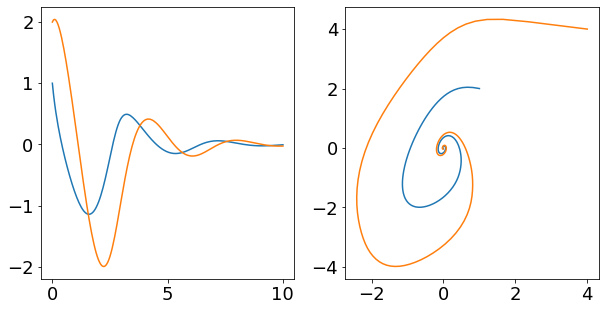

In [ ]:
def jet_engine_model(t, x):
    dfdx = np.zeros((2))
    dfdx[0] = -x[1] - 3/2*x[0]**2 - 1/2*x[0]**3
    dfdx[1] = 3*x[0] - x[1]
    return dfdx

t_sim = [0, 10]
T = np.linspace(t_sim[0], t_sim[1], 200+1)
x0_1 = [1, 2]
x0_2 = [4, 4]
jet_sol_1 = solve_ivp(jet_engine_model, t_sim, x0_1, t_eval=T)
jet_sol_2 = solve_ivp(jet_engine_model, t_sim, x0_2, t_eval=T)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure containing a single axes.
ax[0].plot(jet_sol_1.t, jet_sol_1.y[0])  # Plot some data on the axes.
ax[0].plot(jet_sol_1.t, jet_sol_1.y[1])
ax[1].plot(jet_sol_1.y[0], jet_sol_1.y[1])
ax[1].plot(jet_sol_2.y[0], jet_sol_2.y[1])

In [ ]:
def D_jet(S_i_next):
    # s_i = S_i_next[:, 0]
    # s_next = S_i_next[:, 1]
    s_i = S_i_next[0]
    s_next = S_i_next[1]
    ds_i = s_next - s_i
    M_s_i = M_jet_auto(s_i)
    return np.sqrt(ds_i.dot(M_s_i).dot(ds_i))

In [ ]:
def identity_matrix(x):
    return np.eye(2)

In [ ]:
def compute_geodesic_jet(x1, x2, M_jet_auto, N):
    prog = MathematicalProgram()
    S = prog.NewContinuousVariables(2, N-1, 's_i')
    # prog.AddConstraint(S[0, 0] == x1[0])
    # prog.AddConstraint(S[1, 0] == x1[1])
    # prog.AddConstraint(S[0, N] == x2[0])
    # prog.AddConstraint(S[1, N] == x2[1])

    ds_i = S[:, 0] - x1
    M_s_i = M_jet_auto(x1 + ds_i/2)
    # M_s_i = M_jet_auto(x1)
    # D_i = np.sqrt(ds_i.dot(M_s_i).dot(ds_i))
    D_i = ds_i.dot(M_s_i).dot(ds_i)
    # prog.AddCost(np.sqrt(D_i))
    prog.AddCost(D_i)

    for i in range(N-2):
        ds_i = S[:, i+1] - S[:, i]
        M_s_i = M_jet_auto(S[:, i])
        # D_i = np.sqrt(ds_i.dot(M_s_i).dot(ds_i))
        D_i = ds_i.dot(M_s_i).dot(ds_i)
        # prog.AddCost(np.sqrt(D_i))
        # prog.AddQuadraticCost(2*M_s_i, np.zeros((ds_i.shape[0])), ds_i, is_convex=True)
        prog.AddCost(D_i)
    
    ds_i = x2 - S[:, N-2]
    M_s_i = M_jet_auto(S[:, N-2])
    # D_i = np.sqrt(ds_i.dot(M_s_i).dot(ds_i))
    D_i = ds_i.dot(M_s_i).dot(ds_i)
    # prog.AddCost(np.sqrt(D_i))
    prog.AddCost(D_i)

    # Set an initial guess as equally distanced points in between
    S_0 = np.zeros((2, N-1))
    for i in range(N-1):
        S_0[:, i] = x1 + (x2 - x1)*(i+1)/N

    # solver = MakeSolver(IpoptSolver().solver_id())
    # solver = IpoptSolver() :( Snopt is better)
    solver = SnoptSolver()
    result = solver.Solve(prog)
    if result.is_success():
        S_opt = result.GetSolution(S)
        cost = result.get_optimal_cost()
        return [S_opt, cost]
    else:
        print("result wrong:")
        print(x1, x2)
        return[S_opt, cost]

In [ ]:
x1 = np.array([1, 2])
x2 = np.array([4, 4])
# S_opt, E = compute_geodesic_jet(x1, x2, identity_matrix, N=50)
[S_opt, E] = compute_geodesic_jet(x1, x2, M_jet_auto, N=20)
d_0 = S_opt[:, 0] - x1
E_S = d_0.dot(M_jet_auto(x1)).dot(d_0)
for i in range(18):
    d_i = S_opt[:, i+1] - S_opt[:, i]
    E_S = E_S + d_i.dot(M_jet_auto(S_opt[:, i])).dot(d_i)

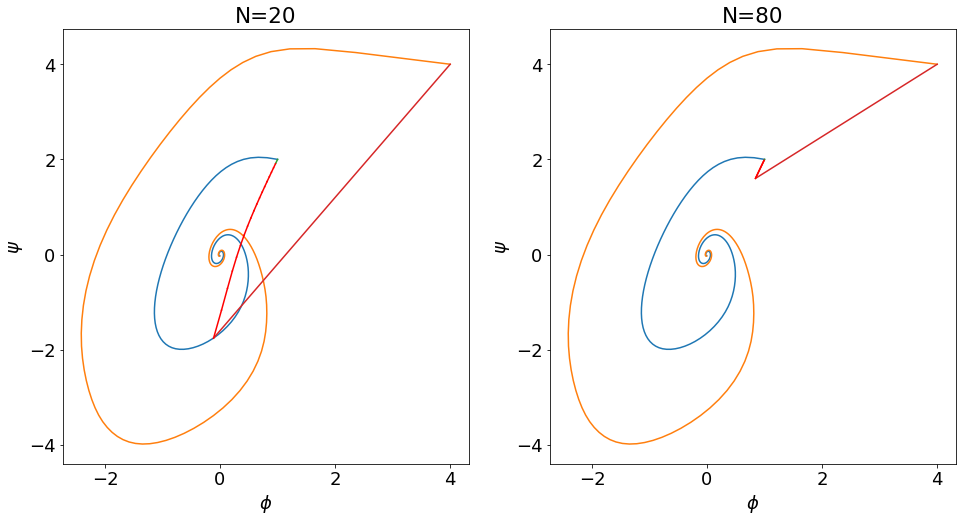

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(jet_sol_1.y[0], jet_sol_1.y[1])
ax[0].plot(jet_sol_2.y[0], jet_sol_2.y[1])
ax[0].plot([x1[0], S_opt[0, 0]], [x1[1], S_opt[1, 0]])
ax[0].plot([S_opt[0, 18], x2[0]], [S_opt[1, 18], x2[1]])
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\psi$")
ax[0].title.set_text("N=20")
for i in range(18):
    ax[0].plot(S_opt[0, i: i+2], S_opt[1, i: i+2], 'r-')


# Compute for N=80
x1 = np.array([1, 2])
x2 = np.array([4, 4])
# S_opt, E = compute_geodesic_jet(x1, x2, identity_matrix, N=50)
[S_opt, E] = compute_geodesic_jet(x1, x2, M_jet_auto, N=80)
d_0 = S_opt[:, 0] - x1
E_S = d_0.dot(M_jet_auto(x1)).dot(d_0)
for i in range(18):
    d_i = S_opt[:, i+1] - S_opt[:, i]
    E_S = E_S + d_i.dot(M_jet_auto(S_opt[:, i])).dot(d_i)

ax[1].plot(jet_sol_1.y[0], jet_sol_1.y[1])
ax[1].plot(jet_sol_2.y[0], jet_sol_2.y[1])
ax[1].plot([x1[0], S_opt[0, 0]], [x1[1], S_opt[1, 0]])
ax[1].plot([S_opt[0, 18], x2[0]], [S_opt[1, 18], x2[1]])
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\psi$")
ax[1].title.set_text('N=80')
for i in range(18):
    ax[1].plot(S_opt[0, i: i+2], S_opt[1, i: i+2], 'r-')
plt.show()

In [ ]:
a = np.zeros((3, 2, 3))
a[0]

array([[0., 0., 0.],
       [0., 0., 0.]])

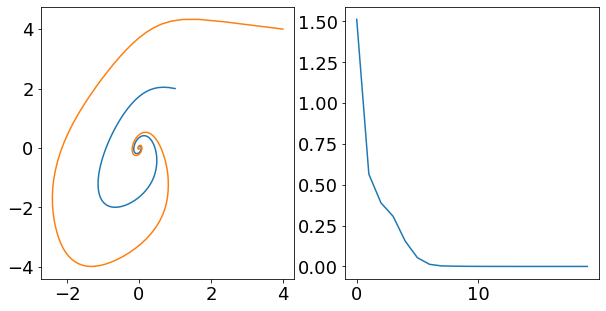

In [ ]:
N_line = 20
N_time = 20
E = np.zeros((N_line, ))
Line_traj = np.zeros((N_time, 2, N_line+1))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(jet_sol_1.y[0], jet_sol_1.y[1])
ax[0].plot(jet_sol_2.y[0], jet_sol_2.y[1])

for i in range(N_time):
    ii = 10*i
    x1 = jet_sol_1.y[:, ii]
    x2 = jet_sol_2.y[:, ii]
    S_opt, _ = compute_geodesic_jet(x1, x2, M_jet_auto, N_line)
    Line_traj[i, :, 0] = x1
    Line_traj[i, :, -1] = x2
    Line_traj[i, :, 1: N_line] = S_opt
    d_0 = S_opt[:, 0] - x1
    E_S = d_0.dot(M_jet_auto(x1)).dot(d_0)
    # ax[0].plot([x1[0], S_opt[0, 0]], [x1[1], S_opt[1, 0]])
    
    for j in range(18):
        d_j = S_opt[:, j+1] - S_opt[:, j]
        E_S = E_S + d_j.dot(M_jet_auto(S_opt[:, j])).dot(d_j)
        # ax[0].plot(S_opt[0, i: i+2], S_opt[1, i: i+2])
    E[i] = E_S
    # ax[0].plot([S_opt[0, 18], x2[0]], [S_opt[1, 18], x2[1]])

ax[1].plot(range(0, 20), E)

Text(0, 0.5, '$\\hat{E}(\\gamma, t)$')

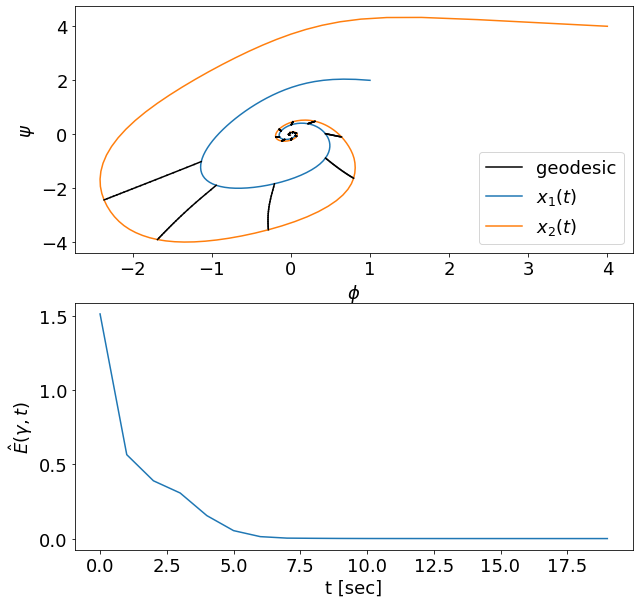

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
traj_1, = ax[0].plot(jet_sol_1.y[0], jet_sol_1.y[1])
traj_2, = ax[0].plot(jet_sol_2.y[0], jet_sol_2.y[1])

for i in range(3, N_time):
    # breakpoint()
    for j in range(N_line):
        geo, = ax[0].plot(Line_traj[i, 0, j: j+2], Line_traj[i, 1, j:j+2], 'k-')
ax[0].set_xlabel(xlabel=r"$\phi$")
ax[0].set_ylabel(ylabel=r"$\psi$")
ax[0].legend([geo, traj_1, traj_2], ['geodesic', '$x_1(t)$', '$x_2(t)$'])
ax[1].plot(range(0, 20), E)
ax[1].set_xlabel(xlabel=r"t [sec]")
ax[1].set_ylabel(ylabel=r"$\hat{E}(\gamma, t)$")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3cb88ae8-1d0d-460e-badc-5bac4a8d012e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>